# Final Project: How to Win a Data Science Competition
# Part 1 - features

I started with Kaggle kernels. Soon I was forced to find a new environment due to memory limitations. I switched to MS Azure Data Science VM (64GB/4CPU/100GbHDD) with their free subscription. Then I realized that you cant get enought computation resources with free subscription and I continued with home PC which has 16Gb/8CPU/SSD.

My pipline is:
* load data
* heal data, remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* merge shops/items/cats to the matrix
* get monthly sales/orders/avg item_price for each item/shop pair in the train set and merge it to the matrix
* add matrix mean encoded features
* merge shops/items/cats to the test set, add date_block_num column = 34
* concat matrix and test
* fill sales and orders column by 0, fill price columns by column median
* add month feature
* clip item_cnt_month by (0,20)
* create lag features fo the [0,1,2,3,4,5,12]th month
* fill nans in the same way as above (every month there are ~30k new itesm/shop pairs compared to the previous monnth)
* cut first year (because of the 12 lag)
* dump matrix to the the file

TODO:
* add number of months between current item/shop pair and last sold one
* add TF-IDF features
* try to add test paris to the matrix within each month

Dont work:
* delta_price and constant_price feature
* is_online, is_mall for shops

In [1]:
import numpy as np
import pandas as pd
import time
import sys

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

sys.version_info

sys.version_info(major=3, minor=5, micro=4, releaselevel='final', serial=0)

## Data

In [23]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv.gz', compression='gzip')
# I set index to avoid removing ID column later
test  = pd.read_csv('test.csv.gz', compression='gzip').set_index('ID') 

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

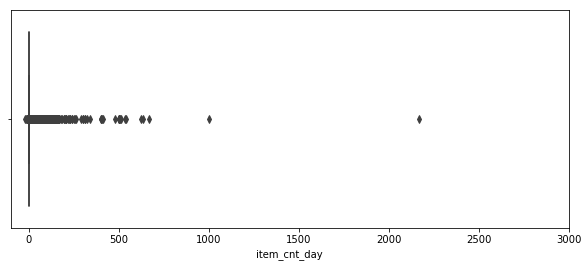

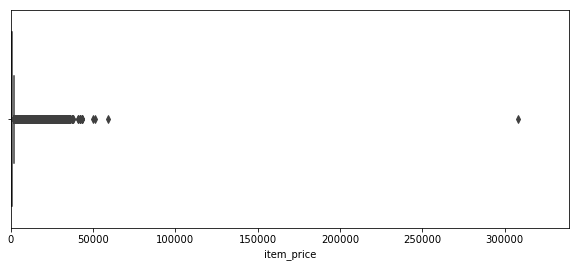

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with the price below zero. Fill it with median.

In [5]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [6]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items
* Each shop_name starts with the city name. Several names should be healed.
* Each category contains type and subtype in its name.

In [7]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

# Monthly sales


In [32]:
ghost_items = pd.DataFrame(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id))))
ghost_items.columns = ['item_id']
pd.merge(ghost_items, items, on='item_id')

,item_id,item_name,item_category_id
0,20486,Фигурка Game Of Thrones Jon Snow Legacy Action...,72
1,6152,"Rise of the Tomb Raider [Xbox 360, русская вер...",23
2,6153,"Rise of the Tomb Raider [Xbox One, русская вер...",24
3,6169,"Rock Band 4 (игра + гитара, барабаны и микрофо...",20
4,14383,МАСТЕР Легенды русского рока (фирм.),55
5,20535,"Фигурка Grindhouse Dakota 7""",72
6,4156,Kaspersky Endpoint Security для бизнеса – Стан...,75
7,10310,ГАННИБАЛ (СР-Пирамида),40
8,20560,Фигурка Heroes Of The Storm Illidan 17см,72
9,20561,Фигурка Heroes Of The Storm Nova 17см,72


In [34]:
items.head(500)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [ ]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    #unique_shops = sales.shop_id.append(test.shop_id).unique()
    #unique_items = sales.item_id.append(test.item_id).unique()
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
print(duration(ts))

In [ ]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [ ]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({
    'item_cnt_day': ['sum', 'count'],
    'item_price': ['mean']
})
group.columns = ['item_cnt_month', 'orders', 'item_price',]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                #.clip(0,20) # TODO clipping should be implement after calculation means
                                .astype(np.float16))
matrix['orders'] = matrix['orders'].fillna(0).astype(np.float16)
matrix['item_price'] = matrix['item_price'].astype(np.float32) #TODO deal with nulls
print(duration(ts))

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum'],
    'item_price': ['mean']
})
group.columns = [ 'date_item_avg_item_cnt', 'date_item_sum_orders', 'date_item_avg_item_price' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix['date_item_sum_orders'] = matrix['date_item_sum_orders'].astype(np.float16)
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float32)
print(duration(ts))

In [ ]:
ts = time.time()
group = matrix.groupby(['shop_id', 'item_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum'],
    'item_price': ['mean']
})
group.columns = [ 'shop_item_avg_item_cnt', 'shop_item_sum_orders', 'shop_item_avg_item_price' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id','item_id'], how='left')
matrix['shop_item_avg_item_cnt'] = matrix['shop_item_avg_item_cnt'].astype(np.float16)
matrix['shop_item_sum_orders'] = matrix['shop_item_sum_orders'].astype(np.float16)
matrix['shop_item_avg_item_price'] = matrix['shop_item_avg_item_price'].astype(np.float32)
print(duration(ts))

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum'],
    'item_price': ['mean']
})
group.columns = [ 'date_shop_avg_item_cnt', 'date_shop_sum_orders', 'date_shop_avg_item_price' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix['date_shop_sum_orders'] = matrix['date_shop_sum_orders'].astype(np.float16)
matrix['date_shop_avg_item_price'] = matrix['date_shop_avg_item_price'].astype(np.float32)
print(duration(ts))

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum'],
    'item_price': ['mean']
})
group.columns = [ 'date_cat_avg_item_cnt', 'date_cat_sum_orders', 'date_cat_avg_item_price' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix['date_cat_sum_orders'] = matrix['date_cat_sum_orders'].astype(np.float16)
matrix['date_cat_avg_item_price'] = matrix['date_cat_avg_item_price'].astype(np.float32)
print(duration(ts))

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({
    'item_cnt_month': ['mean']
})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id','city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
print(duration(ts))

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({
    'item_cnt_month': ['mean']
})
group.columns = [ 'date_shop_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id','type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
print(duration(ts))

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({
    'item_cnt_month': ['mean']
})
group.columns = [ 'date_shop_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id','subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
print(duration(ts))

In [ ]:
test['date_block_num'] = 34
test = pd.merge(test, shops, on='shop_id', how='left')
test = pd.merge(test, items, on='item_id', how='left')
test = pd.merge(test, cats, on='item_category_id', how='left')
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test['city_code'] = test['city_code'].astype(np.int8)
test['item_category_id'] = test['item_category_id'].astype(np.int8)
test['type_code'] = test['type_code'].astype(np.int8)
test['subtype_code'] = test['subtype_code'].astype(np.int8)

In [ ]:
ts = time.time()
#matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols) 
matrix = pd.concat([matrix, test], ignore_index=True, keys=cols)
print(duration(ts))

In [ ]:
def fill_na(df):
    for col in df.columns:
        if df[col].isnull().any():
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
            if ('orders' in col):
                df[col].fillna(0, inplace=True)
            if ('item_price' in col):
                df[col].fillna(df[col].median(), inplace=True)
    return df

In [ ]:
ts = time.time()
matrix = fill_na(matrix)
print(duration(ts))

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12 + 1

In [ ]:
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0, 20)

In [ ]:
def shift(df, month):
    copy = df.drop(['city_code','item_category_id','type_code','subtype_code','month'], axis=1)
    copy['date_block_num'] += month
    return copy

In [ ]:
ts = time.time()
data = matrix
lags = [1, 2, 3, 4, 5, 12]
for i in lags:
    data = pd.merge(data, shift(matrix, i), on=['date_block_num','shop_id','item_id'], how='left',  suffixes=['', '_'+str(i)])

print(duration(ts))

In [ ]:
ts = time.time()
data = data[data.date_block_num > 11]
data.drop(['orders', 'item_price',
       'date_item_avg_item_cnt', 'date_item_sum_orders',
       'date_item_avg_item_price', 'shop_item_avg_item_cnt',
       'shop_item_sum_orders', 'shop_item_avg_item_price',
       'date_shop_avg_item_cnt', 'date_shop_sum_orders',
       'date_shop_avg_item_price', 'date_cat_avg_item_cnt',
       'date_cat_sum_orders', 'date_cat_avg_item_price',
       'date_item_city_avg_item_cnt', 'date_shop_type_avg_item_cnt',
       'date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
print(duration(ts))

In [ ]:
ts = time.time()
data = fill_na(data)
print(duration(ts))

In [ ]:
data.to_pickle('matrix.pickle')

In [ ]:
data.info()